# Data Exploration
- Counting null values in each column and dropping the six columns containing only null values decreased the proportion of nulls in the dataset from 21.1% to 13.6%.

- Explanations for null values may lie in exploring differences between cohorts, sex, or behavioral environments.

- Males and females contributed similarly to total null values; sex does not seem to be the best avenue to pursue at first glance.

- Cohorts 16 and 17 differ from other cohorts in that they each contribute to more than 10% of total null values in the dataset. However, further comparing against the proportion of total animals reveals that cohorts 4 and 16 contribute 1.6 null values per capita, and cohorts 2 and 17 contribute 1.5 null values per capita.

- Similarly, room BSB273B contributes to 23.6% of total null values in the dataset, but it also was used to run 23.5% of all animals in the dataset, so it only contributes to 1.0 null values per capita.

- The top three rooms by null values per capita ran too few animals to draw meaningful conclusions; excluding these, only room MTF134B had a higher null count per capita than BSB273B. Comparing room number against cohort number reveals that 75% of cohort 16 was run in BSB273B, while 100% of cohort 17 was run in MTF134B. The computers in these rooms may have had issues exporting data from Med Associates software because of how the MPC2XL export template was written, or they may have been using MedState Notation programs that were not written to record all the same variables recorded on other computers.

- Condensing the dataset to the most utile columns and re-inspecting null values added some support to exploring cohort and room differences. For the remaining dataset, columns relating to aggressive/defensive behavior counts contributes to approximately 33% of all null values.

- An easy first step to exploring this further would be confirming which animals were excluded from the aggressive/defensive behavior count aspect of the project, and why. If the number of animals excluded and the reasons for excluding those animals does not correlate with the spread of null values, there may be another issue at play for the missing data.

In [1]:
# @title # Load CSV into Pandas DataFrame
import pandas as pd
import numpy as np
df_phenotypes = pd.read_csv('https://raw.githubusercontent.com/eliwagnercode/PalmerLab/main/phenotype_data.csv')
df_phenotypes

,cohort,labanimalid,rfid,sex,box,sha_mean_delta_esc_08_10,sha_mean_08_10,sha_mean_inactive_08_10,sha_mean_to_08_10,sha_loading_phase_intake_08_10,...,sha_coefficient_of_variation_2,lga_coefficient_of_variation,addiction_index_no_sex_z,add_index_sexcohort_z,add_ind_calc_no_z_shock_03,addiction_index_no_sex_z_shock_03_avg1h,add_index_palmer_shock_03_avg1h,add_ind_calc_no_z_shock_03_avg1h,add_ind_olivier,room
0,C01,F1,933000120124701,F,1.0,0.212251,17.666667,2.000000,15.500000,0.0,...,0.000000,0.481828,1.109035,0.873913,1.623640,-0.162999,-0.162999,-0.060136,0.675752,NaN
1,C02,F103,933000120138286,F,6.0,-0.908163,1.666667,1.666667,1.000000,1.0,...,NaN,0.839239,-0.536626,-0.900370,-0.253838,NaN,NaN,NaN,-0.905676,NaN
2,C03,F307,933000120138579,F,7.0,-0.010538,14.333333,2.666667,7.000000,6.0,...,0.687383,1.733507,0.187691,-0.110814,-0.253838,-0.820288,-0.820288,-0.240857,-0.439790,NaN
3,C04,F410,933000120138674,F,10.0,-0.895754,0.666667,3.333333,0.000000,0.0,...,0.000000,2.154435,-0.146594,-0.525034,0.371988,NaN,-1.491529,NaN,-0.313212,NaN
4,C05,F512,933000120138607,F,12.0,0.474365,20.666667,0.666667,2.333333,6.0,...,0.866691,1.520098,-0.818712,-1.301656,-0.253838,3.261822,2.578990,0.708436,-1.316246,MED1110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,C17,M1876,933000320500006,M,10.0,-1.048415,0.333333,1.333333,0.333333,1.0,...,NaN,1.283633,-0.991354,-0.983073,-0.983968,NaN,NaN,NaN,-1.036809,MTF134B
878,C17,M1877,933000320499966,M,9.0,-0.651442,4.666667,1.000000,0.000000,3.0,...,0.923768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MTF134E
879,C17,M1878,933000320499969,M,12.0,-0.865197,2.333333,3.333333,0.000000,4.0,...,1.328527,0.901067,-0.385723,-0.283020,-0.045229,NaN,NaN,NaN,-0.309462,MTF134B
880,C17,M1879,933000320500023,M,13.0,-0.437688,7.000000,21.666667,5.000000,4.0,...,0.903137,0.380199,0.369438,0.422513,-0.879664,NaN,NaN,NaN,0.958922,MTF134B


In [2]:
# @title # DRY functions to count nulls

def get_nullsByCol(df):
  colNulls = df.isna().sum()
  df_colNulls = colNulls.to_frame(name='n_nulls')\
    .rename_axis('column_name')\
    .sort_values('n_nulls',ascending=False)
  print('Total null count in DataFrame: ',df_phenotypes.isna().sum().sum())
  print('Percent null in DataFrame: ',
      round(100*df.isna().sum().sum()\
      /(df.shape[0]*df.shape[1]),1))
  return df_colNulls

# This function would be more efficient using only numpy arrays, but
# it works well for a dataset with fewer than 1000 rows.
def get_nullsByGroup(df,column_name_str):
  df['n_nulls'] = df.isna().sum(axis=1)
  df_valueCounts = df.value_counts(column_name_str)\
    .to_frame(name='n_animals')\
    .rename_axis(column_name_str)\
    .reset_index()

  df_valueCounts['total_values'] = df_valueCounts['n_animals']\
    * df.shape[1]

  df_nulls = df.groupby(column_name_str)['n_nulls'].sum()\
    .to_frame(name='n_nulls')\
    .rename_axis(column_name_str)\
    .reset_index()

  df_nulls = df_nulls.merge(
      df_valueCounts,on=column_name_str)

  percent_group_values = []
  percent_all_animals = []
  percent_all_nulls = []
  nulls_per_capita = []
  n_animals = df_nulls['n_animals'].to_list()
  nulls = df_nulls['n_nulls'].to_list()
  totals = df_nulls['total_values'].to_list()
  for null_count, animal_count, total_count in zip(nulls,n_animals,totals):
    pct_grp_val = round(100*null_count/total_count,1)
    pct_animals = round(100*animal_count/len(df),1)
    pct_nulls = round(100*null_count/df.copy().isna().sum().sum(),1)
    nulls_per_cap = round(pct_nulls/pct_animals,1)
    percent_group_values.append(pct_grp_val)
    percent_all_animals.append(pct_animals)
    percent_all_nulls.append(pct_nulls)
    nulls_per_capita.append(nulls_per_cap)

  df_nulls['percent_group_values'] = percent_group_values
  df_nulls['percent_all_animals'] = percent_all_animals
  df_nulls['percent_all_nulls'] = percent_all_nulls
  df_nulls['nulls_per_capita'] = nulls_per_capita

  df_nulls = df_nulls[[column_name_str,
                       'n_animals',
                       'percent_all_animals',
                       'n_nulls',
                       'percent_group_values',
                       'percent_all_nulls',
                       'nulls_per_capita'
                       ]]

  df_nulls = df_nulls.sort_values(by='percent_group_values',ascending=False)
  return df_nulls

In [3]:
# @title # Count nulls by column
df = get_nullsByCol(df_phenotypes)
df[:10]

Total null count in DataFrame:  12866
Percent null in DataFrame:  21.1


,n_nulls
column_name,
lga_mean_iti,882
sha_rewards_first1hr_2,882
sha_sd_iti_na_2,882
sha_mean_iti_2,882
sha_iti_median_01_03,882
sha_mean_iti,882
irr_total_change,497
irr_agg_change,497
irr_def_change,494


In [4]:
# @title # Drop null-only columns from DataFrame and count nulls by column
colNullsAll = df.loc[
    df['n_nulls'] == len(df_phenotypes)
    ].index.to_list()
df_phenotypes = df_phenotypes.drop(
    columns=colNullsAll)
df = get_nullsByCol(df_phenotypes)
df[:10]

Total null count in DataFrame:  7574
Percent null in DataFrame:  13.6


,n_nulls
column_name,
irr_total_change,497
irr_agg_change,497
irr_def_change,494
irr_age,443
add_ind_calc_no_z_shock_03_avg1h,417
addiction_index_no_sex_z_shock_03_avg1h,417
shock_03_pre,354
shock_03_avg1h,339
sha_coefficient_of_variation_2,330


In [5]:
# @title # Count nulls by cohort
df_cohort = get_nullsByGroup(df_phenotypes,'cohort')
df_cohort

,cohort,n_animals,percent_all_animals,n_nulls,percent_group_values,percent_all_nulls,nulls_per_capita
14,C16,60,6.8,838,21.8,11.1,1.6
3,C04,46,5.2,636,21.6,8.4,1.6
1,C02,46,5.2,609,20.7,8.0,1.5
15,C17,60,6.8,770,20.1,10.2,1.5
0,C01,46,5.2,555,18.9,7.3,1.4
12,C14,60,6.8,660,17.2,8.7,1.3
2,C03,46,5.2,437,14.8,5.8,1.1
9,C11,60,6.8,550,14.3,7.3,1.1
11,C13,59,6.7,524,13.9,6.9,1.0
13,C15,58,6.6,517,13.9,6.8,1.0


In [6]:
# @title # Count nulls by sex
df_sex = get_nullsByGroup(df_phenotypes,'sex')
df_sex

,sex,n_animals,percent_all_animals,n_nulls,percent_group_values,percent_all_nulls,nulls_per_capita
1,M,442,50.1,4000,14.1,52.8,1.1
0,F,440,49.9,3574,12.7,47.2,0.9


In [7]:
# @title # Count nulls by behavior room
df_room = get_nullsByGroup(df_phenotypes,'room')
df_room

,room,n_animals,percent_all_animals,n_nulls,percent_group_values,percent_all_nulls,nulls_per_capita
11,MTF134E,1,0.1,30,46.9,0.4,4.0
9,MTF134C,2,0.2,51,39.8,0.7,3.5
10,MTF134D,12,1.4,300,39.1,4.0,2.9
8,MTF134B,55,6.2,606,17.2,8.0,1.3
0,BSB273B,207,23.5,1784,13.5,23.6,1.0
4,MED1110,62,7.0,495,12.5,6.5,0.9
3,BSB273E,81,9.2,529,10.2,7.0,0.8
1,BSB273C,106,12.0,662,9.8,8.7,0.7
2,BSB273D,115,13.0,686,9.3,9.1,0.7
6,MED1113,21,2.4,112,8.3,1.5,0.6


In [8]:
# @title # Count animals by cohort run in room BSB273B
df_phenotypes[['rfid','cohort','room','box']].loc[(df_phenotypes['room']=='BSB273B')].value_counts('cohort')

cohort
C15    50
C16    45
C08    16
C09    16
C10    16
C11    16
C12    16
C14    16
C13    15
C07     1
dtype: int64

In [9]:
# @title # Count animals by cohort run in room MTF134B
df_phenotypes[['rfid','cohort','room','box']].loc[(df_phenotypes['room']=='MTF134B')].value_counts('cohort')

cohort
C17    53
C16     2
dtype: int64

In [10]:
# @title # Count nulls by behavior room and operant chamber
df_phenotypes['room_box'] = df_phenotypes['room'].astype(str) + '_' + df_phenotypes['box'].astype(str)
df_room_box = get_nullsByGroup(df_phenotypes,'room_box')
df_phenotypes = df_phenotypes.drop(columns='room_box')
df_room_box

,room_box,n_animals,percent_all_animals,n_nulls,percent_group_values,percent_all_nulls,nulls_per_capita
164,nan_nan,2,0.2,100,76.9,1.3,6.5
145,MTF134D_6.0,1,0.1,34,52.3,0.4,4.0
135,MTF134C_16.0,1,0.1,33,50.8,0.4,4.0
139,MTF134D_12.0,1,0.1,31,47.7,0.4,4.0
144,MTF134D_5.0,1,0.1,31,47.7,0.4,4.0
...,...,...,...,...,...,...,...
111,MED1114_2.0,2,0.2,0,0.0,0.0,0.0
112,MED1114_3.0,2,0.2,0,0.0,0.0,0.0
113,MED1114_4.0,2,0.2,0,0.0,0.0,0.0
116,MED1114_7.0,2,0.2,0,0.0,0.0,0.0


In [11]:
# @title # Combine and drop columns
df_phenotypes['sha_mean_total_presses_08_10'] = df_phenotypes[['sha_mean_08_10', 'sha_mean_inactive_08_10',
       'sha_mean_to_08_10']].sum(axis=1)
df_phenotypes['sha_mean_total_presses_01_03'] = df_phenotypes[['sha_mean_01_03', 'sha_mean_inactive_01_03',
       'sha_mean_to_01_03']].sum(axis=1)
df_phenotypes['lga_mean_total_presses_12_14'] = df_phenotypes[['lga_mean_12_14', 'lga_mean_inactive_12_14',
       'lga_mean_to_12_14']].sum(axis=1)
df_phenotypes = df_phenotypes[[
    'cohort', 'rfid', 'sex', 'room','box',
    'sha_mean_01_03','sha_mean_total_presses_01_03',
    'sha_mean_08_10','sha_mean_total_presses_08_10',
    'lga_mean_12_14','lga_mean_total_presses_12_14',
    'shock_03', 'shock_03_pre', 'shock_03_avg1h',
    'pr_01_sha_breakpoint', 'pr_02_lga_breakpoint','pr_03_postshock_breakpoint', 'pr_max_02_03_breakpoint',
    'irr_agg_change', 'irr_def_change', 'irr_total_change',
    'addiction_index_no_sex_z','add_index_sexcohort_z', 'add_ind_calc_no_z_shock_03','addiction_index_no_sex_z_shock_03_avg1h','add_index_palmer_shock_03_avg1h', 'add_ind_calc_no_z_shock_03_avg1h','add_ind_olivier'
]]

In [12]:
# @title # Count nulls by cohort
df_cohort = get_nullsByGroup(df_phenotypes,'cohort')
df_cohort

,cohort,n_animals,percent_all_animals,n_nulls,percent_group_values,percent_all_nulls,nulls_per_capita
14,C16,60,6.8,574,33.0,13.3,2.0
15,C17,60,6.8,525,30.2,12.2,1.8
1,C02,46,5.2,349,26.2,8.1,1.6
0,C01,46,5.2,325,24.4,7.5,1.4
9,C11,60,6.8,355,20.4,8.2,1.2
12,C14,60,6.8,337,19.4,7.8,1.1
13,C15,58,6.6,325,19.3,7.5,1.1
3,C04,46,5.2,252,18.9,5.8,1.1
11,C13,59,6.7,306,17.9,7.1,1.1
2,C03,46,5.2,163,12.2,3.8,0.7


In [13]:
# @title # Count null by sex
df_sex = get_nullsByGroup(df_phenotypes,'sex')
df_sex

,sex,n_animals,percent_all_animals,n_nulls,percent_group_values,percent_all_nulls,nulls_per_capita
1,M,442,50.1,2194,17.1,50.8,1.0
0,F,440,49.9,2123,16.6,49.2,1.0


In [14]:
# @title # Count null by behavior room
df_room = get_nullsByGroup(df_phenotypes,'room')
df_room

,room,n_animals,percent_all_animals,n_nulls,percent_group_values,percent_all_nulls,nulls_per_capita
11,MTF134E,1,0.1,17,58.6,0.4,4.0
10,MTF134D,12,1.4,180,51.7,4.2,3.0
9,MTF134C,2,0.2,29,50.0,0.7,3.5
8,MTF134B,55,6.2,434,27.2,10.1,1.6
0,BSB273B,207,23.5,1051,17.5,24.3,1.0
1,BSB273C,106,12.0,456,14.8,10.6,0.9
3,BSB273E,81,9.2,339,14.4,7.9,0.9
2,BSB273D,115,13.0,449,13.5,10.4,0.8
4,MED1110,62,7.0,176,9.8,4.1,0.6
6,MED1113,21,2.4,57,9.4,1.3,0.5


In [15]:
# @title # Count null by behavior room and operant chamber
df_phenotypes['room_box'] = df_phenotypes['room'].astype(str) + '-' + df_phenotypes['box'].astype(str)
df_room_box = get_nullsByGroup(df_phenotypes,'room_box')
df_phenotypes = df_phenotypes.drop(columns='room_box')
df_room_box

,room_box,n_animals,percent_all_animals,n_nulls,percent_group_values,percent_all_nulls,nulls_per_capita
164,nan-nan,2,0.2,44,73.3,1.0,5.0
147,MTF134E-9.0,1,0.1,17,56.7,0.4,4.0
135,MTF134C-16.0,1,0.1,17,56.7,0.4,4.0
139,MTF134D-12.0,1,0.1,17,56.7,0.4,4.0
141,MTF134D-15.0,1,0.1,17,56.7,0.4,4.0
...,...,...,...,...,...,...,...
113,MED1114-4.0,2,0.2,0,0.0,0.0,0.0
114,MED1114-5.0,2,0.2,0,0.0,0.0,0.0
115,MED1114-6.0,2,0.2,0,0.0,0.0,0.0
116,MED1114-7.0,2,0.2,0,0.0,0.0,0.0


In [16]:
df = df_phenotypes.loc[df_phenotypes['room']=='BSB273B']
get_nullsByCol(df)

Total null count in DataFrame:  4317
Percent null in DataFrame:  17.5


,n_nulls
column_name,
irr_agg_change,165
irr_total_change,165
irr_def_change,165
add_ind_calc_no_z_shock_03_avg1h,76
add_index_palmer_shock_03_avg1h,76
addiction_index_no_sex_z_shock_03_avg1h,76
shock_03_pre,76
shock_03_avg1h,76
shock_03,75


# Stats

- Because there are so many missing values for traits relating to aggressive/defensive behavior, I decided to only explore self-administration for this assignment.

- Because there are no clearly indicated group differences with respect to genotype, treatment, or training context, the only obvious parameters to run group comparisons for behavioral data are sex and age.

- Given more time for the assignment I might classify animals into age brackets and run two-way ANOVA for different traits against age and sex. Because the maximum age for what is seemingly the last experiment in the project, pr_03_age, is only 143 days, and because there is no indication from the dataset that this strain of animal is a model of age-related disorders, I decided to focus only on exploring sex differences.

- Outliers were defined as those with values further than 1.5x the IQR away from the first or third quartile. Outliers were only removed before grouping by sex. Upon inspecting within groups, it appeared that groups had visibly different spreads.

- Independent t-tests for short access rewards, short access total responses, long access rewards, and long access total responses revealed p-values of 6.152e-11, 1.063e-11, 4.534e-11, and 4.744e-12 respectively, entreating the rejection of the null-hypothesis for differences between sex.

- These results evoke questions of whether this self-administration paradigm controlled for bodyweight differences between males and females by using a higher concentration of cocaine in saline for males than for females, and regularly updating concentrations based on average group bodyweight. Assuming so, these results are in line with literature documenting differences in acquisition and maintenance of cocaine self-administration in rats.

In [17]:
# @title #DRY function to remove outliers
def get_outliersOut(df,column_name_str):
  df2 = df.copy()
  Q1 = df2[column_name_str].quantile(0.25)
  Q3 = df2[column_name_str].quantile(0.75)
  IQR = Q3 - Q1
  lower = Q1 - 1.5*IQR
  upper = Q3 + 1.5*IQR
  df2 = df2.loc[
      (df2[column_name_str]<=upper)
      & (df2[column_name_str]>=lower)]
  return df2

In [18]:
# @title # Encode sex column with numeric value
encode_sex = []
for sex in df_phenotypes['sex'].to_list():
  if sex == 'F':
    encode_sex.append(0)
  else:
    encode_sex.append(1)
df_phenotypes['isMale'] = encode_sex

count    877.000000
mean      15.129038
std       16.048474
min        0.000000
25%        2.000000
50%        9.666667
75%       25.666667
max      114.000000
Name: sha_mean_08_10, dtype: float64


<Axes: >

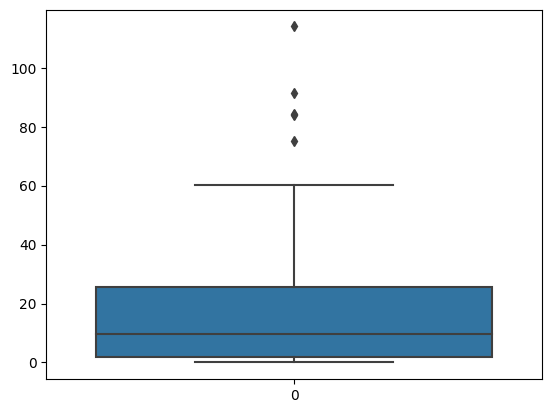

In [19]:
# @title # Inspect ShA for outliers
import seaborn as sns
print(df_phenotypes['sha_mean_08_10'].describe())
sns.boxplot(df_phenotypes['sha_mean_08_10'])

count    856.000000
mean      85.808217
std       47.957093
min        0.000000
25%       56.666667
50%       96.000000
75%      119.000000
max      280.000000
Name: lga_mean_12_14, dtype: float64


<Axes: >

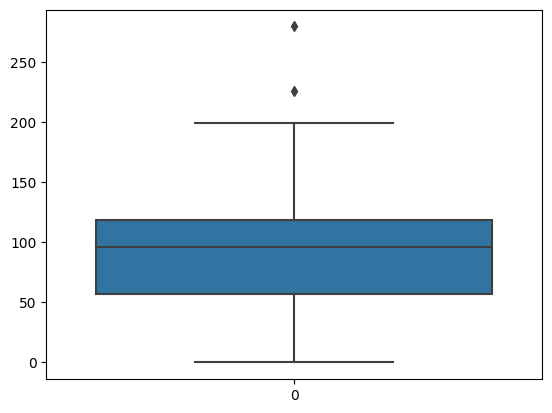

In [20]:
# @title # Inspect LgA for outliers
import seaborn as sns
print(df_phenotypes['lga_mean_12_14'].describe())
sns.boxplot(df_phenotypes['lga_mean_12_14'])

In [21]:
# @title # Remove outliers and group by sex
df_sha_rw = get_outliersOut(df_phenotypes,'sha_mean_08_10')
df_sha_rw = df_sha_rw[['rfid','isMale','sha_mean_08_10']].dropna()
males_sha_rw = df_sha_rw.loc[df_sha_rw['isMale']==1].reset_index(drop=True)
females_sha_rw = df_sha_rw.loc[df_sha_rw['isMale']==0].reset_index(drop=True)

df_sha_rp = get_outliersOut(df_phenotypes,'sha_mean_total_presses_08_10')
df_sha_rp = df_sha_rp[['rfid','isMale','sha_mean_total_presses_08_10']].dropna()
males_sha_rp = df_sha_rp.loc[df_sha_rp['isMale']==1].reset_index(drop=True)
females_sha_rp = df_sha_rp.loc[df_sha_rp['isMale']==0].reset_index(drop=True)

df_lga_rw = get_outliersOut(df_phenotypes,'lga_mean_12_14')
df_lga_rw = df_lga_rw[['rfid','isMale','lga_mean_12_14']].dropna()
males_lga_rw = df_lga_rw.loc[df_lga_rw['isMale']==1].reset_index(drop=True)
females_lga_rw = df_lga_rw.loc[df_lga_rw['isMale']==0].reset_index(drop=True)

df_lga_rp = get_outliersOut(df_phenotypes,'lga_mean_total_presses_12_14')
df_lga_rp = df_lga_rp[['rfid','isMale','lga_mean_total_presses_12_14']].dropna()
males_lga_rp = df_lga_rp.loc[df_lga_rp['isMale']==1].reset_index(drop=True)
females_lga_rp = df_lga_rp.loc[df_lga_rp['isMale']==0].reset_index(drop=True)

count    439.000000
mean      11.432802
std       12.388518
min        0.000000
25%        2.000000
50%        7.000000
75%       17.500000
max       60.000000
Name: sha_mean_08_10, dtype: float64
Axes(0.125,0.11;0.775x0.77)


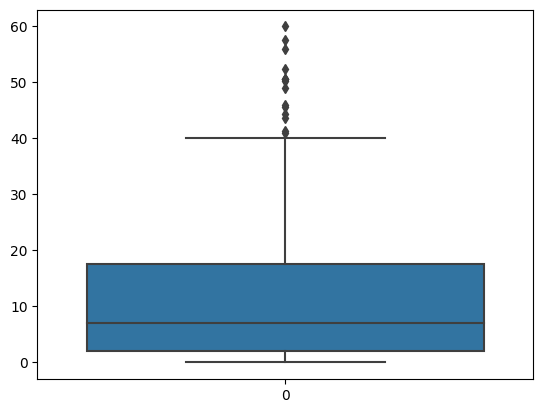

In [22]:
# @title # Inspect male ShA
print(males_sha_rw['sha_mean_08_10'].describe())
print(sns.boxplot(males_sha_rw['sha_mean_08_10']))

count    433.000000
mean      18.015012
std       16.672988
min        0.000000
25%        2.000000
50%       14.000000
75%       31.000000
max       60.333333
Name: sha_mean_08_10, dtype: float64
Axes(0.125,0.11;0.775x0.77)


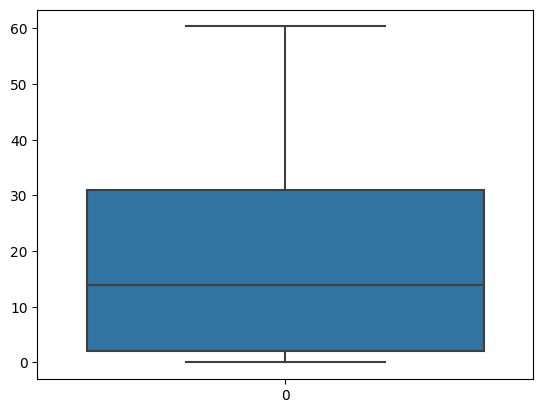

In [23]:
# @title # Inspect female ShA
print(females_sha_rw['sha_mean_08_10'].describe())
print(sns.boxplot(females_sha_rw['sha_mean_08_10']))

count    428.000000
mean      74.905763
std       46.197551
min        0.000000
25%       27.583333
50%       88.833333
75%      109.833333
max      192.333333
Name: lga_mean_12_14, dtype: float64
Axes(0.125,0.11;0.775x0.77)


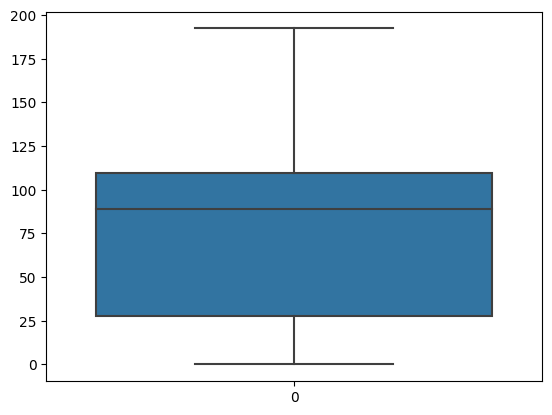

In [24]:
# @title # Inspect male LgA
print(males_lga_rw['lga_mean_12_14'].describe())
print(sns.boxplot(males_lga_rw['lga_mean_12_14']))

count    426.000000
mean      95.976135
std       46.087296
min        0.000000
25%       70.416667
50%      107.000000
75%      129.333333
max      199.666667
Name: lga_mean_12_14, dtype: float64
Axes(0.125,0.11;0.775x0.77)


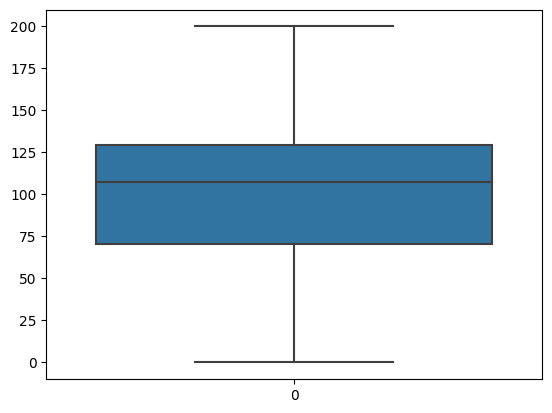

In [25]:
# @title # Inspect female LgA
print(females_lga_rw['lga_mean_12_14'].describe())
print(sns.boxplot(females_lga_rw['lga_mean_12_14']))

In [27]:
# @title # t-tests
from scipy.stats import ttest_ind
print('Male vs Female ShA Rewards:\n',ttest_ind(males_sha_rw['sha_mean_08_10'],females_sha_rw['sha_mean_08_10']))
print('Male vs Female ShA Active + Inactive + TO:\n',ttest_ind(males_sha_rp['sha_mean_total_presses_08_10'],females_sha_rp['sha_mean_total_presses_08_10']))
print('Male vs Female LgA Rewards:\n',ttest_ind(males_lga_rw['lga_mean_12_14'],females_lga_rw['lga_mean_12_14']))
print('Male vs Female LgA Active + Inactive + TO:\n',ttest_ind(males_lga_rp['lga_mean_total_presses_12_14'],females_lga_rp['lga_mean_total_presses_12_14']))

Male vs Female ShA Rewards:
 Ttest_indResult(statistic=-6.623157067648685, pvalue=6.151706165286693e-11)
Male vs Female ShA Active + Inactive + TO:
 Ttest_indResult(statistic=-6.893179858884703, pvalue=1.0632697228210661e-11)
Male vs Female LgA Rewards:
 Ttest_indResult(statistic=-6.672183941207495, pvalue=4.5340177327043944e-11)
Male vs Female LgA Active + Inactive + TO:
 Ttest_indResult(statistic=-7.014172951565482, pvalue=4.744333761525975e-12)
